ELEC6910X Advanced Topics in AI and Healthcare

# Assignment 1 - Problem 3: Surgical Phase Recognition

***Holy Lovenia - 20814158***

------

In [2]:
from collections import OrderedDict
from PIL import Image
from pytorch_metric_learning import losses
from torch import nn
from torch.autograd import Variable
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
from transformers import AutoConfig, AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from tqdm import tqdm

import datasets
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import surface_distance.metrics as sf
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchio as tio
import torchmetrics
import torchvision

In [3]:
RANDOM_SEED = 42

def set_all_seeds(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

set_all_seeds(RANDOM_SEED)

## Problem 3: Surgical Phase Recognition

In [4]:
NUM_CLASSES = 7

In [5]:
model_name_or_path = "microsoft/resnet-50"

### Data loading

#### Function declaration

Loading function for `problem3_datas` dataset.

In [263]:
def problem3_load_dataset(
    manifest_dir_path,
    vid_dir_path,
    only_these_ids=[],
    num_prev_frames=0,
    img_column_name="Frame",
    label_column_name="Phase",
    return_df=False):
    
    all_manifest_dfs = []
    
    for manifest_file_name in os.listdir(manifest_dir_path):
        data_id = int(manifest_file_name.split("_")[-1].replace(".csv", ""))
        if data_id in only_these_ids:
            manifest_path = os.path.join(manifest_dir_path, manifest_file_name)
            manifest_df = pd.read_csv(manifest_path)
            manifest_df["video_id"] = data_id
            manifest_df[img_column_name] = f"{os.path.join(vid_dir_path, str(data_id))}/" + manifest_df[img_column_name].astype(str)
            manifest_df = manifest_df.rename(columns={img_column_name: "image", label_column_name: "label"})

            if num_prev_frames != 0:
                prev_frames = {}
                prev_labels = {}
                total_num_frames = len(manifest_df)
                for current_frame_id in range(total_num_frames):
                    for n_before_current in range(num_prev_frames):
                        if prev_frames.get(n_before_current) is None:
                            prev_frames[n_before_current] = []
                            prev_labels[n_before_current] = []
                    
                        if current_frame_id - n_before_current >= 0:
                            prev_frames[n_before_current].append(
                                manifest_df["image"][current_frame_id - n_before_current])
                            prev_labels[n_before_current].append(
                                manifest_df["label"][current_frame_id - n_before_current])
                        else:
                            prev_frames[n_before_current].append(None)
                            prev_labels[n_before_current].append(None)
                            
                for n_before_current in range(num_prev_frames):
                    manifest_df[f"prev_frame_{n_before_current}"] = prev_frames[n_before_current]
                    manifest_df[f"prev_label_{n_before_current}"] = prev_labels[n_before_current]
            
            all_manifest_dfs.append(manifest_df)
    whole_manifest_df = pd.concat(all_manifest_dfs, ignore_index=True)
        
    dataset = datasets.Dataset.from_pandas(whole_manifest_df)
    dataset = dataset.cast_column("image", datasets.Image(decode=True))
    if num_prev_frames != 0:
        for n_before_current in range(num_prev_frames):
            dataset = dataset.cast_column(f"prev_frame_{n_before_current}", datasets.Image(decode=True))
            dataset = dataset.cast_column(f"prev_label_{n_before_current}", datasets.Value("int32"))
#     print("after image", len(dataset))
#     dataset = dataset.class_encode_column("label")
#     print("after casting", len(dataset))
#     dataset.features["label"].names = [
#         "Preparation",
#         "Calot Triangle Dissection",
#         "Clipping Cutting",
#         "Gallbladder Dissection",
#         "Gallbladder Packaging",
#         "Cleaning Coagulation",
#         "Gallbladder Retraction"]
    if return_df:
        return dataset, whole_manifest_df
    else:
        return dataset

#### Function utilization

Load the `problem3_datas` dataset.

In [264]:
raw_datasets = datasets.DatasetDict()
raw_datasets["train"], train_df = problem3_load_dataset(
    "./data/problem3_datas/annotation/",
    "./data/problem3_datas/",
    num_prev_frames=5,
    only_these_ids=range(1, 6),
    return_df=True)
raw_datasets["valid"] = problem3_load_dataset(
    "./data/problem3_datas/annotation/",
    "./data/problem3_datas/",
    num_prev_frames=5,
    only_these_ids=[41],
    return_df=False)
raw_datasets

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'video_id', 'prev_frame_0', 'prev_label_0', 'prev_frame_1', 'prev_label_1', 'prev_frame_2', 'prev_label_2', 'prev_frame_3', 'prev_label_3', 'prev_frame_4', 'prev_label_4'],
        num_rows: 3570
    })
    valid: Dataset({
        features: ['image', 'label', 'video_id', 'prev_frame_0', 'prev_label_0', 'prev_frame_1', 'prev_label_1', 'prev_frame_2', 'prev_label_2', 'prev_frame_3', 'prev_label_3', 'prev_frame_4', 'prev_label_4'],
        num_rows: 776
    })
})

Display the label statistics of the `problem3_datas` dataset.

In [86]:
label_stats = train_df["label"].value_counts()
label_stats

1    163
3    146
2     53
4     24
6     23
5     19
0      6
Name: label, dtype: int64

Wow, so imbalanced. Let's get the class weights. They can be used to adjust the cross-entropy loss later.

In [48]:
num_train_labels = sum(label_stats)
train_class_weights = []
for i in range(NUM_CLASSES):
    train_class_weights.append(float(round(train_df["label"].value_counts()[i] / num_train_labels, 2)))
train_class_weights

[0.01, 0.38, 0.12, 0.34, 0.06, 0.04, 0.05]

What do the data look like? Let's display a data sample of each class in the `problem2_datas`.

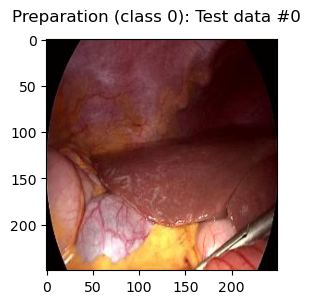

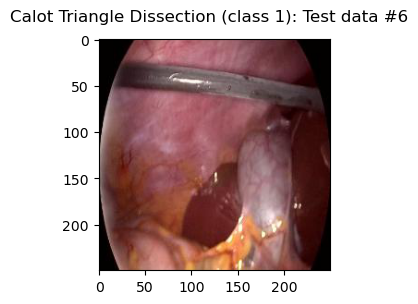

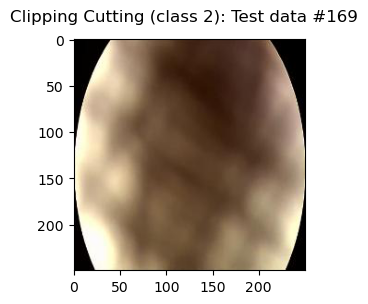

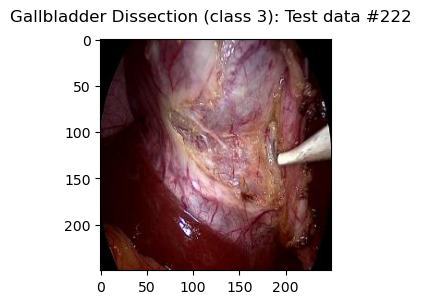

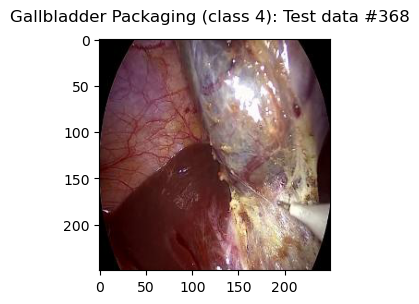

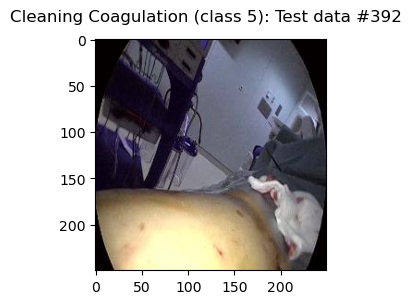

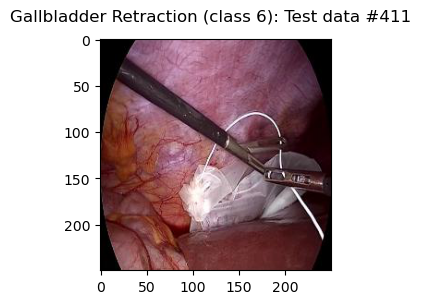

In [49]:
for class_id in range(NUM_CLASSES):
    # Get the index of the first sample from `class_id`
    index = train_df.index[train_df["label"] == class_id][0]
    plt.figure(figsize=(4, 3))
    plt.suptitle(f'{raw_datasets["train"].features["label"].names[class_id]} (class {class_id}): Test data #{index}', fontsize=12)
    plt.imshow(raw_datasets["train"][int(index)]["image"])

### Preprocessing

Initialize the feature extractor I want to use.

In [50]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name_or_path)

#### Function declarations

Augmentation and preprocessing functions.

In [51]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
#             Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
#             RandomHorizontalFlip(),
#             RandomVerticalFlip(),
            ToTensor(),
            normalize,
        ]
    )

eval_transforms = Compose(
        [
#             Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_eval(example_batch):
    """Apply eval_transforms across a batch."""
    example_batch["pixel_values"] = [
        eval_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

Data collator.

This will be useful for batched data processing later.

In [52]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

#### Function utilization

Don't forget to preprocess both the `problem2_datas` dataset and the `HAM10000` dataset.

In [15]:
proc_datasets = raw_datasets
proc_datasets["train"].set_transform(preprocess_train)
proc_datasets["valid"].set_transform(preprocess_eval)

In [16]:
proc_pretrain_datasets = pretrain_datasets
proc_pretrain_datasets["train"].set_transform(preprocess_train)
proc_pretrain_datasets["valid"].set_transform(preprocess_eval)

### Training and evaluation

#### Function declarations

Modified Trainer.

Use the pre-computed `train_class_weights` to adjust the cross entropy loss.

In [17]:
class SkinLesionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to("cuda")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits").to("cuda")
        # compute weighted cross entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(train_class_weights + [0 for i in range(993)])).to("cuda")
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Accuracy evaluation metric.

In [18]:
metric = datasets.load_metric("accuracy")

/tmp/ipykernel_20175/3770023701.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("accuracy")


In [19]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Evaluation.

In [20]:
def evaluation(trainer, datasets=[], eval_names=[]):
    for dset, name in zip(datasets, eval_names):
        metrics = trainer.evaluate(dset)
        trainer.log_metrics(name, metrics)
        trainer.save_metrics(name, metrics)

Pre-training loop.

In [21]:
def pretraining(
    model,
    output_dir=f"save/problem2/pretrain__{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_pretrain_datasets["train"],
    eval_dataset=proc_pretrain_datasets["valid"],
    trainer_class=SkinLesionTrainer):
    
    args = TrainingArguments(
        output_dir,
        remove_unused_columns=False,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=1e-3,
        per_device_train_batch_size=32,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=32,
        num_train_epochs=200,
        warmup_ratio=0.1,
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        gradient_checkpointing=True,
        save_total_limit=1,
        seed=RANDOM_SEED,
        data_seed=RANDOM_SEED,
        dataloader_num_workers=4,
        lr_scheduler_type="cosine",
        fp16=True,
        report_to="wandb",
        run_name=output_dir,
    )
    
    trainer = trainer_class(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=feature_extractor,
        compute_metrics=compute_metrics,
        data_collator=collate_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],
    )
    
    train_results = trainer.train()
    trainer.save_model()
    
    return trainer

Training loop.

In [22]:
def training(
    model,
    output_dir=f"save/problem2/{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"],
    trainer_class=SkinLesionTrainer,
):
    args = TrainingArguments(
        output_dir,
        remove_unused_columns=False,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=1e-3,
        per_device_train_batch_size=32,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=32,
        num_train_epochs=200,
        warmup_ratio=0.1,
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        gradient_checkpointing=True,
        save_total_limit=1,
        seed=RANDOM_SEED,
        data_seed=RANDOM_SEED,
        dataloader_num_workers=4,
        lr_scheduler_type="cosine",
        fp16=True,
        report_to="wandb",
        run_name=output_dir, 
    )
    
    trainer = trainer_class(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=feature_extractor,
        compute_metrics=compute_metrics,
        data_collator=collate_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=20)],
    )
    
    train_results = trainer.train()
    trainer.save_model()
    
    return trainer

### Experiment 1: Default/Normal

In [23]:
exp1_model = AutoModelForImageClassification.from_pretrained(model_name_or_path)

In [24]:
trainer = training(
    exp1_model,
    output_dir=f"save/problem2/default__{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"],
    trainer_class=Trainer)

Using cuda_amp half precision backend
/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 305
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: holylovenia. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,7.084044,0.000000
1,No log,7.134549,0.000000
2,No log,7.376381,0.000000
3,No log,7.223563,0.000000
4,8.972900,6.901674,0.000000
5,8.972900,6.383523,0.000000
6,8.972900,5.731494,0.020202
7,8.972900,4.803751,0.282828
8,8.972900,3.588485,0.515152
9,7.115400,2.838811,0.606061


***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-2
Configuration saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-2/config.json
Model weights saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-2/pytorch_model.bin
Feature extractor saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-2/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-4
Configuration saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-4/config.json
Model weights saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-4/pytorch_model.bin
Feature extractor saved in save/problem2/default__microsoft/resnet-152__1e-3__submitte

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-28
Configuration saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-28/config.json
Model weights saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-28/pytorch_model.bin
Feature extractor saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-28/preprocessor_config.json
Deleting older checkpoint [save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-24] due to args.save_total_limit
Deleting older checkpoint [save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-26] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-30
Configuration saved in save/problem2/defa

Feature extractor saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-52/preprocessor_config.json
Deleting older checkpoint [save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-50] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-54
Configuration saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-54/config.json
Model weights saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-54/pytorch_model.bin
Feature extractor saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-54/preprocessor_config.json
Deleting older checkpoint [save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-52] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model che

Saving model checkpoint to save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-78
Configuration saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-78/config.json
Model weights saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-78/pytorch_model.bin
Feature extractor saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-78/preprocessor_config.json
Deleting older checkpoint [save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-76] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-80
Configuration saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-80/config.json
Model weights saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-80/pytorch_model.bin
Feature extracto

Feature extractor saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-102/preprocessor_config.json
Deleting older checkpoint [save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-104
Configuration saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-104/config.json
Model weights saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-104/pytorch_model.bin
Feature extractor saved in save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-104/preprocessor_config.json
Deleting older checkpoint [save/problem2/default__microsoft/resnet-152__1e-3__submitted/checkpoint-102] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving mo

In [25]:
evaluation(
    trainer,
    datasets=[proc_datasets["valid"]],
    eval_names=["problem2_datas__valid"]
)

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32


***** problem2_datas__valid metrics *****
  epoch                   =       59.8
  eval_accuracy           =     0.7576
  eval_loss               =     1.2493
  eval_runtime            = 0:00:01.36
  eval_samples_per_second =     72.572
  eval_steps_per_second   =      2.932


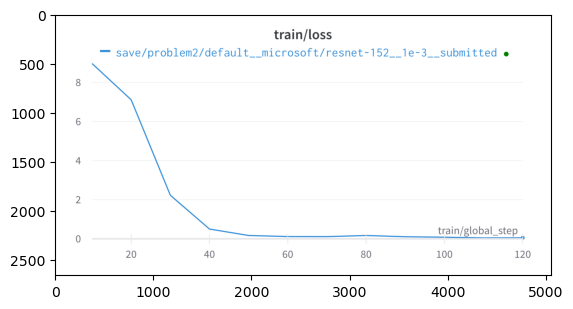

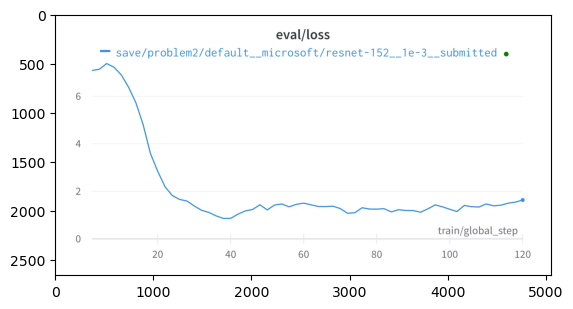

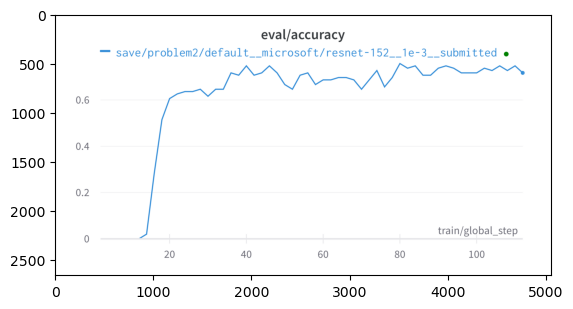

In [26]:
plt.figure()
img = mpimg.imread("./log/problem2/exp1/exp1_train_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/exp1/exp1_valid_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/exp1/exp1_valid_acc.png")
plt.imshow(img)

### Experiment 2: Weighted Cross-Entropy Loss

In [23]:
exp2_model = AutoModelForImageClassification.from_pretrained(model_name_or_path)

In [24]:
trainer = training(
    exp2_model,
    output_dir=f"save/problem2/{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"])

Using cuda_amp half precision backend
/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 305
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: holylovenia. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,7.047606,0.000000
1,No log,7.053577,0.000000
2,No log,7.399084,0.000000
3,No log,7.270785,0.000000
4,9.018300,6.764757,0.000000
5,9.018300,5.824580,0.010101
6,9.018300,5.067624,0.090909
7,9.018300,3.895259,0.333333
8,9.018300,2.491891,0.535354
9,6.515600,1.651899,0.616162


***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-2
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-2/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-2/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-2/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-108] due to args.save_total_limit
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-148] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-4
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-4/config.json
Model w

Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-28/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-28/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-28/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-30
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-30/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-30/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-30/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-28] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-56
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-56/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-56/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-56/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-46] due to args.save_total_limit
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-54] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-58
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-58/config.json
Mod

Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-82/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-82/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-80] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-84
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-84/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-84/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-84/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-82] due to args.save_total_limit
***** Running Evaluation *****
  Num exam

Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-108/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-106] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-110
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-110/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-110/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-110/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-112
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-112/config.json


Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-136
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-136/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-136/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-136/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-134] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-138
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-138/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-138/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/c

In [25]:
evaluation(
    trainer,
    datasets=[proc_datasets["valid"]],
    eval_names=["problem2_datas__valid"]
)

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32


***** problem2_datas__valid metrics *****
  epoch                   =       73.8
  eval_accuracy           =     0.8283
  eval_loss               =     0.2194
  eval_runtime            = 0:00:01.64
  eval_samples_per_second =     60.227
  eval_steps_per_second   =      2.433


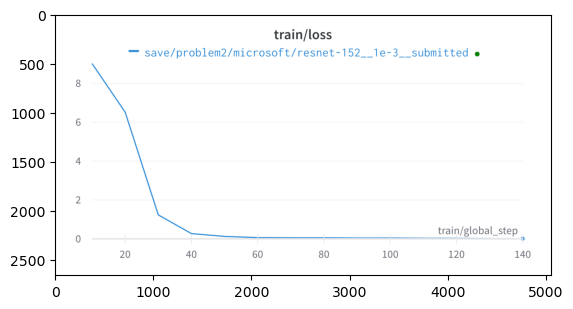

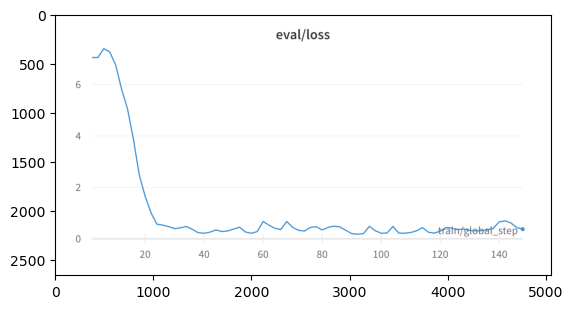

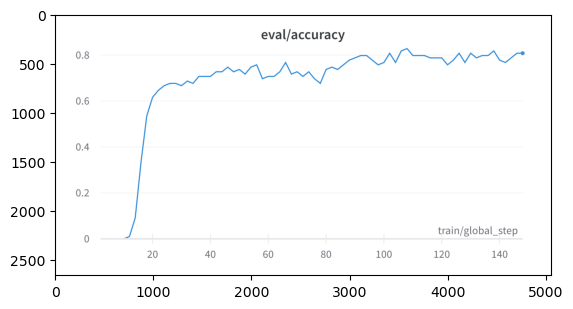

In [35]:
plt.figure()
img = mpimg.imread("./log/problem2/exp2/exp2_train_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/exp2/exp2_valid_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/exp2/exp2_valid_acc.png")
plt.imshow(img)

### Experiment 3: Experiment 2 + Pre-training

Pre-training.

In [36]:
exp3_pretraining_model = AutoModelForImageClassification.from_pretrained(model_name_or_path)

loading configuration file config.json from cache at /home/holy/.cache/huggingface/hub/models--microsoft--resnet-152/snapshots/26958355fd2ec78b3e07b7094b8778c242907844/config.json
Model config ResNetConfig {
  "_name_or_path": "microsoft/resnet-152",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    8,
    36,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduel

loading weights file pytorch_model.bin from cache at /home/holy/.cache/huggingface/hub/models--microsoft--resnet-152/snapshots/26958355fd2ec78b3e07b7094b8778c242907844/pytorch_model.bin
All model checkpoint weights were used when initializing ResNetForImageClassification.

All the weights of ResNetForImageClassification were initialized from the model checkpoint at microsoft/resnet-152.
If your task is similar to the task the model of the checkpoint was trained on, you can already use ResNetForImageClassification for predictions without further training.


In [37]:
pretrainer = pretraining(
    exp3_pretraining_model,
    output_dir=f"save/problem2/pretrain__{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_pretrain_datasets["train"],
    eval_dataset=proc_pretrain_datasets["valid"])

PyTorch: setting up devices
Using cuda_amp half precision backend
/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1600
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 2400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy
0,7.536400,7.284433,0.000000
1,7.589800,6.353826,0.005000
2,6.775900,4.979838,0.210000
3,5.656800,2.077876,0.587500
4,1.677900,1.081237,0.715000
5,0.899600,0.609056,0.732500
6,0.543500,0.480014,0.737500
7,0.342800,0.427933,0.805000
8,0.336500,0.398646,0.787500
9,0.265300,0.475188,0.805000


***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12/config.json
Model weights saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12/pytorch_model.bin
Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-72] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-24
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-24/config.json
Model weights saved in save/problem2/pretrain__microso

Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-156/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-144] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-168
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-168/config.json
Model weights saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-168/pytorch_model.bin
Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-168/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-156] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32


***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-312
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-312/config.json
Model weights saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-312/pytorch_model.bin
Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-312/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-300] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-324
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-324/config.json
Model weights saved in save/problem2/pretrain__

Model weights saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-456/pytorch_model.bin
Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-456/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-420] due to args.save_total_limit
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-444] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-468
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-468/config.json
Model weights saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-468/pytorch_model.bin
Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__su

In [38]:
evaluation(
    pretrainer,
    datasets=[proc_pretrain_datasets["valid"], proc_datasets["valid"]],
    eval_names=["ham10000__valid", "problem2_datas__valid"]
)

***** Running Evaluation *****
  Num examples = 400
  Batch size = 32


***** Running Evaluation *****
  Num examples = 99
  Batch size = 32


***** ham10000__valid metrics *****
  epoch                   =      47.96
  eval_accuracy           =     0.8775
  eval_loss               =     0.4481
  eval_runtime            = 0:00:02.86
  eval_samples_per_second =    139.503
  eval_steps_per_second   =      4.534
***** problem2_datas__valid metrics *****
  epoch                   =      47.96
  eval_accuracy           =     0.1818
  eval_loss               =     8.9857
  eval_runtime            = 0:00:01.48
  eval_samples_per_second =     66.747
  eval_steps_per_second   =      2.697


Fine-tuning.

In [24]:
exp3_finetuning_model = AutoModelForImageClassification.from_pretrained(
    f"save/problem2/pretrain__{model_name_or_path}__1e-3__submitted")

In [25]:
trainer = training(
    exp3_finetuning_model,
    output_dir=f"save/problem2/pretrained__1e-3|{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"])

Using cuda_amp half precision backend
/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 305
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: holylovenia. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,9.743649,0.181818
1,No log,9.509656,0.191919
2,No log,8.557146,0.181818
3,No log,7.036314,0.181818
4,10.672100,5.320508,0.181818
5,10.672100,3.856836,0.212121
6,10.672100,3.416615,0.272727
7,10.672100,2.804009,0.383838
8,10.672100,1.785927,0.535354
9,4.037200,0.968431,0.616162


***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-2
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-2/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-2/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-2/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-4
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-4/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-4/pytorch_model.bin
Feature extractor saved in sav

  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-26
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-26/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-26/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-26/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-28
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-28/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-28/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-50
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-50/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-50/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-50/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-52
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-52/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-52/pytorch_model.bin
Feature extractor saved

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-74
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-74/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-74/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-74/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-72] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-76
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-76/config.json
Model w

Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-96/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-98
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-98/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-98/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-98/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-96] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/chec

Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-120/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-118] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-122
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-122/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-122/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-122/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-120] due to args.save_total_limit
***** Running Evaluati

In [26]:
evaluation(
    trainer,
    datasets=[proc_datasets["valid"]],
    eval_names=["problem2_datas__valid"]
)

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32


***** problem2_datas__valid metrics *****
  epoch                   =       66.8
  eval_accuracy           =     0.8485
  eval_loss               =     0.2739
  eval_runtime            = 0:00:01.28
  eval_samples_per_second =     76.975
  eval_steps_per_second   =       3.11


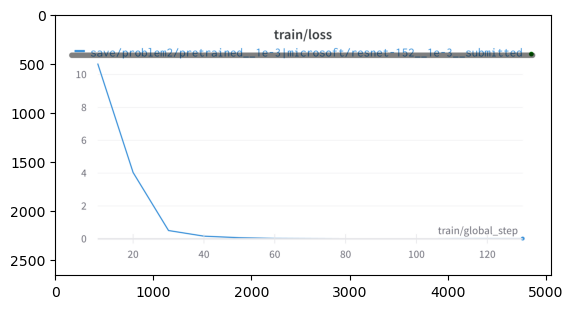

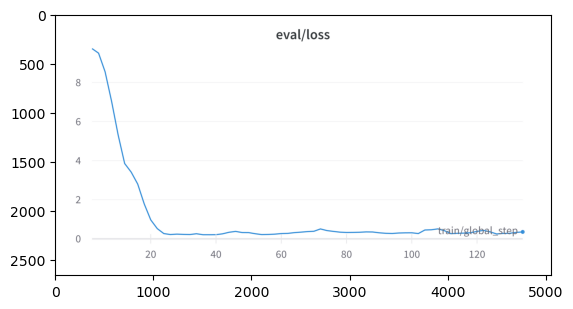

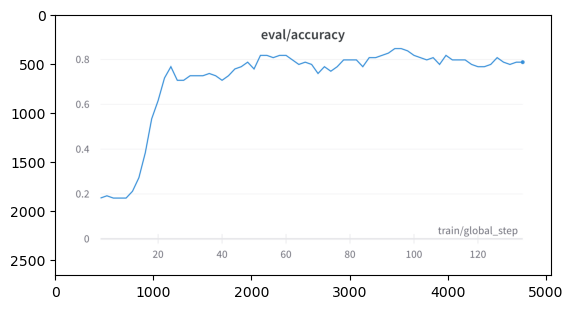

In [29]:
plt.figure()
img = mpimg.imread("./log/problem2/exp3/exp3_train_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/exp3/exp3_valid_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/exp3/exp3_valid_acc.png")
plt.imshow(img)

### Experiment 4: Experiment 2 + Contrastive Loss

#### Function declarations

Modify Trainer to incorporate contrastive loss.

In [23]:
class SkinLesionWithContrastiveLearningTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to("cuda")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits").to("cuda")
        # compute weighted cross entropy loss
        con_loss_fct = losses.SupConLoss()
        ce_loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(train_class_weights + [0 for i in range(993)])).to("cuda")
        ce_loss = ce_loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        con_loss = con_loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        loss = ce_loss + con_loss
        return (loss, outputs) if return_outputs else loss

#### Function utilization

In [38]:
exp4_model = AutoModelForImageClassification.from_pretrained(model_name_or_path)

loading configuration file config.json from cache at /home/holy/.cache/huggingface/hub/models--microsoft--resnet-152/snapshots/26958355fd2ec78b3e07b7094b8778c242907844/config.json
Model config ResNetConfig {
  "_name_or_path": "microsoft/resnet-152",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    8,
    36,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduel

loading weights file pytorch_model.bin from cache at /home/holy/.cache/huggingface/hub/models--microsoft--resnet-152/snapshots/26958355fd2ec78b3e07b7094b8778c242907844/pytorch_model.bin
All model checkpoint weights were used when initializing ResNetForImageClassification.

All the weights of ResNetForImageClassification were initialized from the model checkpoint at microsoft/resnet-152.
If your task is similar to the task the model of the checkpoint was trained on, you can already use ResNetForImageClassification for predictions without further training.


In [39]:
trainer = training(
    exp4_model,
    output_dir=f"save/problem2/con__{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"],
    trainer_class=SkinLesionWithContrastiveLearningTrainer)

PyTorch: setting up devices
Using cuda_amp half precision backend
***** Running training *****
  Num examples = 305
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,10.398209,0.000000
1,No log,10.404078,0.000000
2,No log,10.749628,0.000000
3,No log,10.604155,0.000000
4,13.066300,10.041531,0.000000
5,13.066300,9.161851,0.010101
6,13.066300,8.235914,0.131313
7,13.066300,6.968581,0.404040
8,13.066300,5.618059,0.606061
9,10.799700,4.961116,0.626263


***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-2
Configuration saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-2/config.json
Model weights saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-2/pytorch_model.bin
Feature extractor saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-2/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-4
Configuration saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-4/config.json
Model weights saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-4/pytorch_model.bin
Feature extractor saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-4/preprocessor_conf

Model weights saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-28/pytorch_model.bin
Feature extractor saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-28/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-26] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-30
Configuration saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-30/config.json
Model weights saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-30/pytorch_model.bin
Feature extractor saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-30/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-28] due to args.save_total_limit
*

Model weights saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-54/pytorch_model.bin
Feature extractor saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-54/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-52] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-56
Configuration saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-56/config.json
Model weights saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-56/pytorch_model.bin
Feature extractor saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-56/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-54] due to args.save_total_limit
*

Model weights saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-80/pytorch_model.bin
Feature extractor saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-80/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-78] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-82
Configuration saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-82/config.json
Model weights saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-82/pytorch_model.bin
Feature extractor saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-82/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-66] due to args.save_total_limit
D

Model weights saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-106/pytorch_model.bin
Feature extractor saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-106/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-104] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-108
Configuration saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-108/config.json
Model weights saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-108/pytorch_model.bin
Feature extractor saved in save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-108/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__microsoft/resnet-152__1e-3__submitted/checkpoint-106] due to args.save_total

In [40]:
evaluation(
    trainer,
    datasets=[proc_datasets["valid"]],
    eval_names=["problem2_datas__valid"]
)

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32


***** problem2_datas__valid metrics *****
  epoch                   =       60.8
  eval_accuracy           =      0.798
  eval_loss               =     3.4279
  eval_runtime            = 0:00:01.43
  eval_samples_per_second =     69.172
  eval_steps_per_second   =      2.795


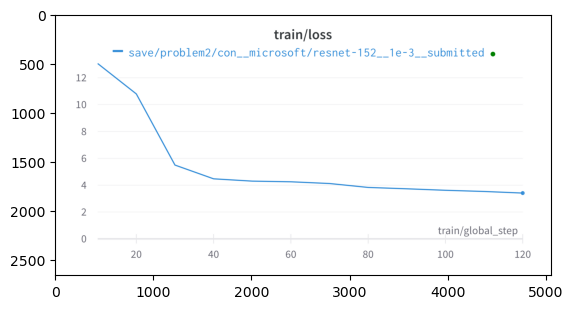

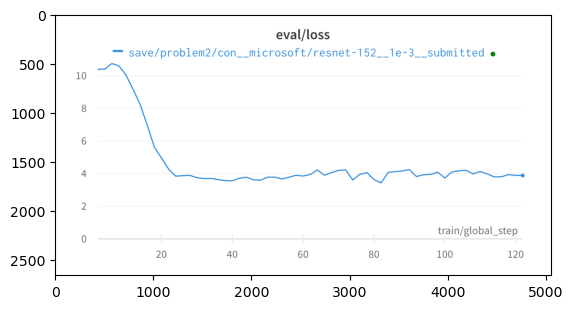

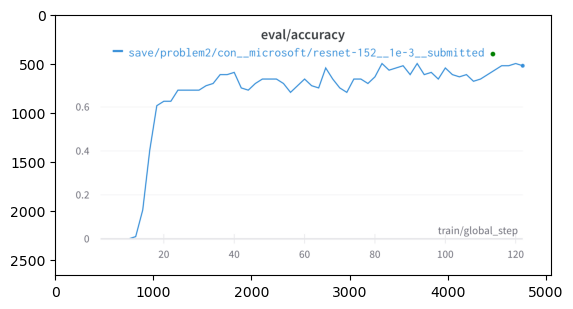

In [41]:
plt.figure()
img = mpimg.imread("./log/problem2/exp4/exp4_train_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/exp4/exp4_valid_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/exp4/exp4_valid_acc.png")
plt.imshow(img)

### Experiment 5: Experiment + Contrastive Loss

Pre-training.

In [42]:
exp5_pretraining_model = AutoModelForImageClassification.from_pretrained(model_name_or_path)

loading configuration file config.json from cache at /home/holy/.cache/huggingface/hub/models--microsoft--resnet-152/snapshots/26958355fd2ec78b3e07b7094b8778c242907844/config.json
Model config ResNetConfig {
  "_name_or_path": "microsoft/resnet-152",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    8,
    36,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduel

loading weights file pytorch_model.bin from cache at /home/holy/.cache/huggingface/hub/models--microsoft--resnet-152/snapshots/26958355fd2ec78b3e07b7094b8778c242907844/pytorch_model.bin
All model checkpoint weights were used when initializing ResNetForImageClassification.

All the weights of ResNetForImageClassification were initialized from the model checkpoint at microsoft/resnet-152.
If your task is similar to the task the model of the checkpoint was trained on, you can already use ResNetForImageClassification for predictions without further training.


In [43]:
pretrainer = pretraining(
    exp5_pretraining_model,
    output_dir=f"save/problem2/con__pretrain__{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_pretrain_datasets["train"],
    eval_dataset=proc_pretrain_datasets["valid"],
    trainer_class=SkinLesionWithContrastiveLearningTrainer)

PyTorch: setting up devices
Using cuda_amp half precision backend
/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1600
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 2400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy
0,10.969400,10.695669,0.000000
1,11.193500,9.758973,0.002500
2,10.405200,8.093212,0.265000
3,9.206100,5.459701,0.607500
4,5.064100,4.423902,0.700000
5,4.425800,4.119769,0.727500
6,4.185500,3.886396,0.770000
7,4.012500,3.872811,0.767500
8,3.945600,4.154722,0.705000
9,3.680100,3.942826,0.775000


***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12
Configuration saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12/config.json
Model weights saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12/pytorch_model.bin
Feature extractor saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-24
Configuration saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-24/config.json
Model weights saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-24/pytorch_model.bin
Feature extractor saved in save/pro

Saving model checkpoint to save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-156
Configuration saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-156/config.json
Model weights saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-156/pytorch_model.bin
Feature extractor saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-156/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-144] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-168
Configuration saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-168/config.json
Model weights saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__su

Configuration saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-300/config.json
Model weights saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-300/pytorch_model.bin
Feature extractor saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-300/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-276] due to args.save_total_limit
Deleting older checkpoint [save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-288] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-312
Configuration saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-312/config.json
Model weights saved in save/problem2/con__pretrain__

Saving model checkpoint to save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-444
Configuration saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-444/config.json
Model weights saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-444/pytorch_model.bin
Feature extractor saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-444/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-432] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-456
Configuration saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-456/config.json
Model weights saved in save/problem2/con__pretrain__microsoft/resnet-152__1e-3__su

In [44]:
evaluation(
    pretrainer,
    datasets=[proc_pretrain_datasets["valid"], proc_datasets["valid"]],
    eval_names=["ham10000__valid", "problem2_datas__valid"]
)

***** Running Evaluation *****
  Num examples = 400
  Batch size = 32


***** Running Evaluation *****
  Num examples = 99
  Batch size = 32


***** ham10000__valid metrics *****
  epoch                   =      43.96
  eval_accuracy           =      0.875
  eval_loss               =     3.5814
  eval_runtime            = 0:00:02.91
  eval_samples_per_second =    137.305
  eval_steps_per_second   =      4.462
***** problem2_datas__valid metrics *****
  epoch                   =      43.96
  eval_accuracy           =      0.202
  eval_loss               =    12.6324
  eval_runtime            = 0:00:01.51
  eval_samples_per_second =     65.536
  eval_steps_per_second   =      2.648


Fine-tuning.

In [24]:
exp5_finetuning_model = AutoModelForImageClassification.from_pretrained(
    f"save/problem2/con__pretrain__{model_name_or_path}__1e-3__submitted")

In [25]:
trainer = training(
    exp5_finetuning_model,
    output_dir=f"save/problem2/con__pretrained__1e-3|con__{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"],
    trainer_class=SkinLesionWithContrastiveLearningTrainer)

Using cuda_amp half precision backend
/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 305
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: holylovenia. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,14.676527,0.181818
1,No log,14.874621,0.171717
2,No log,14.012050,0.171717
3,No log,12.130822,0.171717
4,18.171800,10.656482,0.181818
5,18.171800,9.065087,0.242424
6,18.171800,7.702439,0.363636
7,18.171800,6.523671,0.414141
8,18.171800,5.483545,0.515152
9,9.588300,4.603342,0.585859


***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-2
Configuration saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-2/config.json
Model weights saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-2/pytorch_model.bin
Feature extractor saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-2/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-4
Configuration saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-4/config.json
Model weights saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__s

Configuration saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-24/config.json
Model weights saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-24/pytorch_model.bin
Feature extractor saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-24/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-22] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-26
Configuration saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-26/config.json
Model weights saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-26/pytorch_mo

Feature extractor saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-46/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-44] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-48
Configuration saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-48/config.json
Model weights saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-48/pytorch_model.bin
Feature extractor saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-48/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/che

Feature extractor saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-68/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-66] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-70
Configuration saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-70/config.json
Model weights saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-70/pytorch_model.bin
Feature extractor saved in save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/checkpoint-70/preprocessor_config.json
Deleting older checkpoint [save/problem2/con__pretrained__1e-3|con__microsoft/resnet-152__1e-3__submitted/che

In [26]:
evaluation(
    trainer,
    datasets=[proc_datasets["valid"]],
    eval_names=["problem2_datas__valid"]
)

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32


***** problem2_datas__valid metrics *****
  epoch                   =       38.8
  eval_accuracy           =     0.8586
  eval_loss               =     3.3357
  eval_runtime            = 0:00:01.38
  eval_samples_per_second =     71.357
  eval_steps_per_second   =      2.883


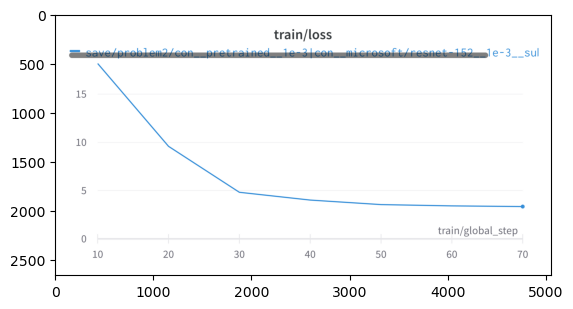

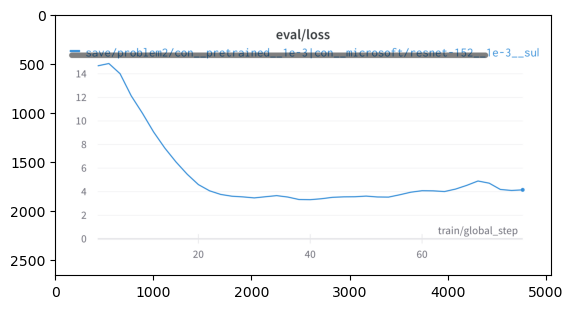

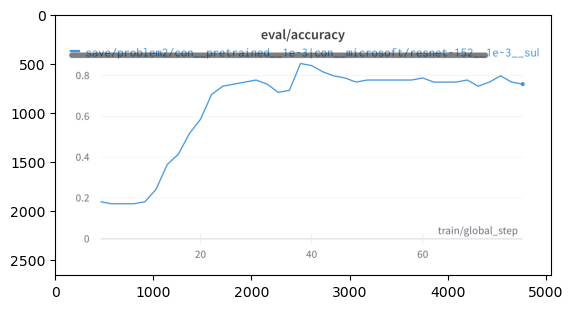

In [28]:
plt.figure()
img = mpimg.imread("./log/problem2/exp5/exp5_train_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/exp5/exp5_valid_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/exp5/exp5_valid_acc.png")
plt.imshow(img)

### Conclusion

|Exp. ID|Exp. Setting|Eval. Acc.|
|-------|------------|----------|
|1|Cross entropy (CE) loss|75.76%|
|2|Weighted CE loss|82.83%|
|3|Weighted CE loss + pre-training|<u>84.85%</u>|
|4|Supervised contrastive (SupCon) loss + weighted CE loss|79.80%|
|5|SupCon loss + weighted CE loss + pre-training|**85.86%**|

In this notebook, I have:

1) tried out 5 different experiment configurations (including adding a contrastive loss to the cross-entropy loss);

2) reported the results (i.e., train loss, eval loss, and eval accuracy); and

3) achieved a best performance of 85.86% using ResNet-152 (through Experiment 5) for skin lesion classification.